# 图像分类数据集
使用**Fashion-MNIST**

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中。

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data",train=True,
                                               transform=trans,
                                               download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data",train=False,
                                              transform=trans,
                                               download=True)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

# 两个可视化数据集的函数

In [4]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            #图片张量
            ax.imshow(img.numpy())
        else:
            #PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# 几个样本的图像及其相应的标签

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f57414a4610>,
      dtype=object)

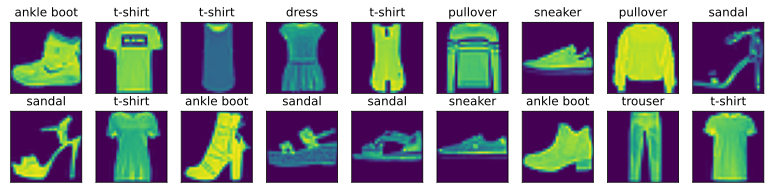

In [5]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28), 2,9,titles=get_fashion_mnist_labels(y))

In [6]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取的数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue

f'{timer.stop():.2f} sec'

'1.19 sec'

## 整合所有组件

现在我们定义了 `load_data_fashion_mnist` 函数，用于获取和读取Fashion-MNIST数据集。它返回训练集和验证集的数据迭代器。此外，它还接受一个可选参数，用来将图像大小调整为另一种形状。

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

# softmax回归的从零开始实现

In [8]:
import torch 
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

将展平每个图像，将它们视为长度为784的向量.因为我们的数据集有10个类别，所以网络输出维度为 10。

In [9]:
num_inputs = 784 #28*28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

给定一个矩阵`X`，我们可以对所有元素求和

In [10]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

softmax 由三个步骤组成：
（1）对每个项求幂（使用`exp`）；
（2）对每一行求和（小批量中每个样本是一行），得到每个样本的归一化常数；
（3）将每一行除以其归一化常数，确保结果的和为1。
在查看代码之前，让我们回顾一下这个表达式：

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

分母或归一化常数，有时也称为*配分函数*（其对数称为对数-配分函数）。该名称的起源来自 [统计物理学](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))中一个模拟粒子群分布的方程。

In [11]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition #这里应用了广播

我们将每个元素变成一个非负数。此外，依据概率的要求，每行总和为1。

In [12]:
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2783, 0.1354, 0.0975, 0.4109, 0.0778],
         [0.0889, 0.1355, 0.0823, 0.3405, 0.3528]]),
 tensor([1.0000, 1.0000]))

## 实现softmax模型

In [13]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W) + b)

创建一个数据`y_hat`，其中包含2个样本在3个类别的预测概率,使用`y`作为`y_hat`中概率的索引

In [14]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1], y]

tensor([0.1000, 0.5000])

## 实现交叉熵损失函数。

In [15]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 将预测类别与真实`y`元素进行比较

In [16]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat, y) / len(y)

0.5

## 我们可以评估在任意模型`net`的准确率

In [17]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

`Accumulator` 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量。

In [18]:
class Accumulator:
    """在`n`个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [19]:
evaluate_accuracy(net, test_iter)

0.1008

In [20]:
def train_epoch_ch3(net,train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                    float(l) * len(y), accuracy(y_hat, y),
                    y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

定义了一个在动画中绘制数据的实用程序类

In [21]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 训练函数

In [22]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

小批量随机梯度下降来优化模型的损失函数

In [23]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)

训练模型10个迭代周期

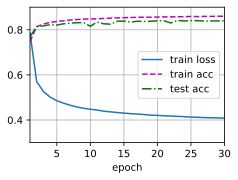

In [24]:
num_epochs = 30
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

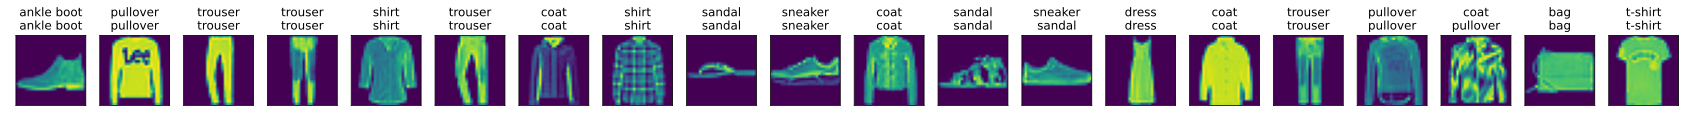

In [29]:
def predict_ch3(net, test_iter, n=20):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# softmax回归的简洁实现

In [30]:
import torch 
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

softmax 回归的输出层是一个全连接层

In [31]:
# PyTorch不会隐式地调整输入的形状。
# 因此，我们定义了展平层（flatten）在线性层前调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

在交叉熵损失函数中传递未归一化的预测并同时计算softmax及其对数

In [32]:
loss = nn.CrossEntropyLoss()

使用学习率为0.1的小批量随机梯度下降作为优化算法

In [33]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

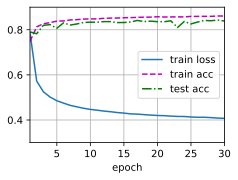

In [35]:
num_epochs = 30
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)